In [10]:
from pandas import read_csv,to_datetime, DataFrame
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import zscore
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from ydata_profiling import ProfileReport
from numpy import array, newaxis
from tslearn.clustering import TimeSeriesKMeans, silhouette_score,KShape, KernelKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.cluster import DBSCAN
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score


## Le Clustering des continent n'a pas l'ai très pertinent car les barycentre des différents groupes n'arrivent pas à bien représenter l'évolution des courbes 

## Faire un clustering de l'évolution des familles produits dans le temps 

## On va lire les fichiers du dossier de fichiers 

In [11]:
def read_csv_and_plot_common_column(directory,  date_Col):  
    # Liste pour stocker les DataFrames
    dataframes = []
    
    # Lire tous les fichiers CSV dans le dossier
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory, filename)
            df = read_csv(file_path)

            df[date_Col] = to_datetime(df[date_Col])
            df = df.set_index(date_Col)
            df = df.drop(columns=['Unnamed: 0'], errors='ignore')

            # Resampler les ventes par mois
            df = df[['QTE']].resample('ME').sum()

            df.name = os.path.splitext(filename)[0]  # Attribuer le nom du fichier au DataFrame
            dataframes.append(df)
    return dataframes

In [12]:
def read_csv_test(directory,  date_Col):  
    # Liste pour stocker les DataFrames
    dataframes = []
    
    # Lire tous les fichiers CSV dans le dossier
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory, filename)
            df = read_csv(file_path)

            df[date_Col] = to_datetime(df[date_Col])
            df = df.set_index(date_Col)
            df = df.drop(columns=['Unnamed: 0'], errors='ignore')

            # Resampler les ventes par mois
            df = df[['QTE']].resample('YE').sum()
            #df = df[~((df.index.year == 2020) & (df.index.month == 1))]
            df.name = os.path.splitext(filename)[0]  # Attribuer le nom du fichier au DataFrame
            dataframes.append(df)
    return dataframes

In [13]:
AlldfContinent = read_csv("D:\Alternance_2023_UTT\MS EBDE UTT 23 Prof thesis\Sample_Data\Processed\Product families over time.csv")
df2 = AlldfContinent.set_index('Product Family').T
df2.index = to_datetime(df2.index)


<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
D:\WK\ydongue\AppData\Local\Temp\ipykernel_26348\4125408222.py:1: SyntaxWarning: invalid escape sequence '\A'
  AlldfContinent = read_csv("D:\Alternance_2023_UTT\MS EBDE UTT 23 Prof thesis\Sample_Data\Processed\Product families over time.csv")


## Clustering des courbes KMEANS

In [14]:
# Conversion du DataFrame en numpy array
X = df2.T.values

# Normaliser les séries temporelles
#scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
#scaler = zscore()
#series_scaled = scaler.fit_transform(X)
series_scaled = zscore(X)
n_clusters = 3  # Nombre de clusters souhaité
metrics = ["dtw", "softdtw", "euclidean"]

results = []

for metrique in metrics:
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric=metrique, n_init=150, max_iter=100, random_state=0)
    labels = model.fit_predict(series_scaled)

    # Métriques d'évaluation
    silhouette_avg = silhouette_score(series_scaled, labels, metric=metrique)

    series_scaled_2d = series_scaled.reshape(series_scaled.shape[0], -1)
    calinski_harabasz = calinski_harabasz_score(series_scaled_2d, labels)
    davies_bouldin = davies_bouldin_score(series_scaled_2d, labels)

    results.append({
        "Metric": metrique,
        "Silhouette Score": silhouette_avg,
        "Calinski-Harabasz Score": calinski_harabasz,
        "Davies-Bouldin Index": davies_bouldin
    })

results_df = DataFrame(results)
print(results_df)

KeyboardInterrupt: 

## KShape

In [ ]:
X = df2.T.values

# Normaliser les séries temporelles
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
#series_scaled = scaler.fit_transform(X)
series_scaled = zscore(X)
n_clusters = 3  # Nombre de clusters souhaité

model = KShape(n_clusters=n_clusters, n_init=150, max_iter=100, random_state=0)
labels = model.fit_predict(series_scaled)

# Métriques d'évaluation

silhouette_avg = silhouette_score(series_scaled, labels, metric=metrique)

series_scaled_2d = series_scaled.reshape(series_scaled.shape[0], -1)
calinski_harabasz = calinski_harabasz_score(series_scaled_2d, labels)
davies_bouldin = davies_bouldin_score(series_scaled_2d, labels)


print("Silhouette Score: ", silhouette_avg)
print("Calinski-Harabasz Score: ", calinski_harabasz)
print("Davies-Bouldin Index: ", davies_bouldin)


KeyboardInterrupt: 

d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 17 1-dimensional timeseries
  warnings.warn(


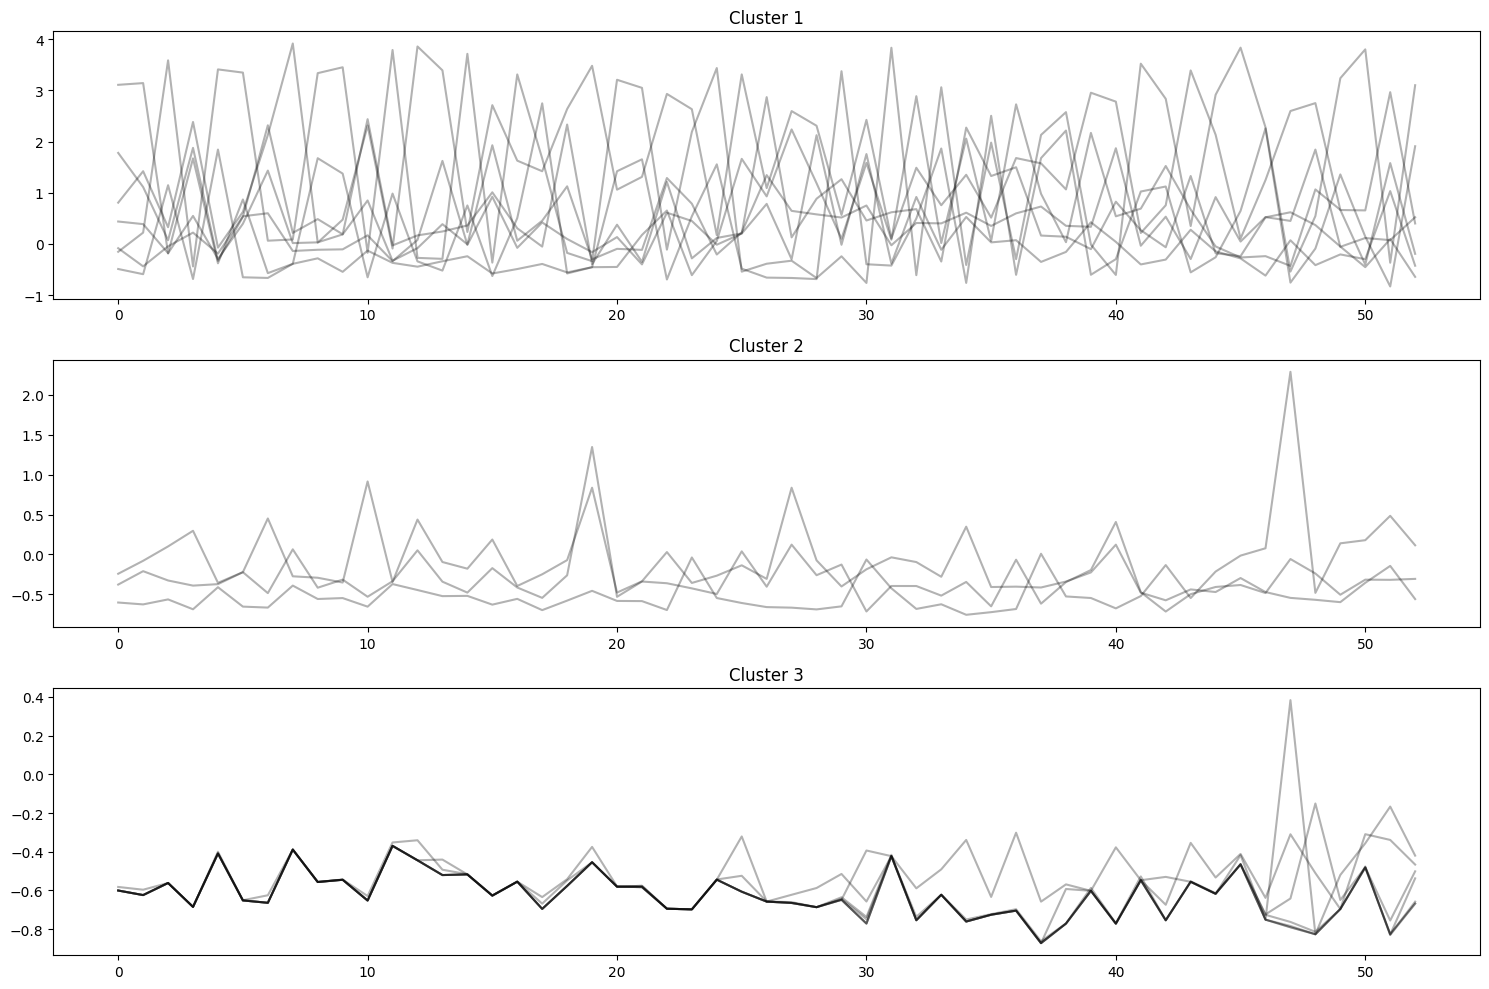

array([0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 2, 2, 1, 2, 2, 2, 2], dtype=int64)

In [15]:
X = df2.T.values

# Normaliser les séries temporelles
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
#series_scaled = scaler.fit_transform(X)
series_scaled = zscore(X)
n_clusters = 3  # Nombre de clusters souhaité

model = KernelKMeans(n_clusters=n_clusters, kernel="gak", kernel_params={"sigma": "auto"}, n_init=150, max_iter=100, random_state=0)
labels = model.fit_predict(series_scaled)

# Affichage des clusters
plt.figure(figsize=(15, 10))
for cluster in range(n_clusters):
    plt.subplot(n_clusters, 1, cluster + 1)
    for i in range(len(labels)):
        if labels[i] == cluster:
            plt.plot(series_scaled[i].ravel(), "k-", alpha=0.3)
    plt.title(f"Cluster {cluster + 1}")
plt.tight_layout()
plt.show()

labels

## KernelKMeans

In [16]:
X = df2.T.values

# Normaliser les séries temporelles
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
#series_scaled = scaler.fit_transform(X)
series_scaled = zscore(X)
n_clusters = 3  # Nombre de clusters souhaité
#"additive_chi2","chi2",
metrics = [ "gak",  "linear", "poly", "polynomial", "rbf", "laplacian", "sigmoid", "cosine"]
#metrics = ["gak", "additive_chi2", "chi2", "linear", "poly", "polynomial", "rbf", "laplacian", "sigmoid", "cosine"]

results2 = []

for metrique in metrics:
    print("Clustering avec la métrique", metrique)
    if metrique =="gak":
        model = KernelKMeans(n_clusters=n_clusters, kernel=metrique, kernel_params={"sigma": "auto"}, n_init=150, max_iter=100, random_state=0)
        labels = model.fit_predict(series_scaled)
    else : 
        model = KernelKMeans(n_clusters=n_clusters, kernel=metrique, n_init=150, max_iter=100, random_state=0)
        labels = model.fit_predict(series_scaled)
        
    # Métriques d'évaluation
    silhouette_avg = silhouette_score(series_scaled, labels)#, metric=metrique)
    series_scaled_2d = series_scaled.reshape(series_scaled.shape[0], -1)
    calinski_harabasz = calinski_harabasz_score(series_scaled_2d, labels)
    davies_bouldin = davies_bouldin_score(series_scaled_2d, labels)

    results2.append({
        "Kernel": metrique,
        "Silhouette Score": silhouette_avg,
        "Calinski-Harabasz Score": calinski_harabasz,
        "Davies-Bouldin Index": davies_bouldin
    })

results_df2 = DataFrame(results2)
print(results_df2)

Clustering avec la métrique gak
Clustering avec la métrique linear
Clustering avec la métrique poly
Clustering avec la métrique polynomial


d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 17 1-dimensional timeseries
  warnings.warn(
d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 17 1-dimensional timeseries
  warnings.warn(
d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 17 1-dimensional timeseries
  warnings.warn(
d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 17 1-dimensional timeseries
  warnings.warn(


Clustering avec la métrique rbf
Clustering avec la métrique laplacian
Clustering avec la métrique sigmoid
Clustering avec la métrique cosine
       Kernel  Silhouette Score  Calinski-Harabasz Score  Davies-Bouldin Index
0         gak          0.458070                 6.483393              1.734820
1      linear          0.490750                13.390662              0.884798
2        poly          0.490750                13.390662              0.884798
3  polynomial          0.490750                13.390662              0.884798
4         rbf          0.488137                 8.647459              1.280741
5   laplacian          0.490750                13.390662              0.884798
6     sigmoid          0.490750                13.390662              0.884798
7      cosine          0.490750                13.390662              0.884798


d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 17 1-dimensional timeseries
  warnings.warn(
d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 17 1-dimensional timeseries
  warnings.warn(
d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 17 1-dimensional timeseries
  warnings.warn(
d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 17 1-dimensional timeseries
  warnings.warn(


In [17]:
"""
# Appliquer k-means avec DTW
n_clusters = 2  # Par exemple, 2 clusters
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42, max_iter=500)
labels = model.fit_predict(series_scaled)

# Afficher les résultats
for df, label in zip(AlldfContinent, labels):
    print(f"Continent: {df.name}, Cluster: {label}")
"""

'\n# Appliquer k-means avec DTW\nn_clusters = 2  # Par exemple, 2 clusters\nmodel = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42, max_iter=500)\nlabels = model.fit_predict(series_scaled)\n\n# Afficher les résultats\nfor df, label in zip(AlldfContinent, labels):\n    print(f"Continent: {df.name}, Cluster: {label}")\n'

## Hierarchical clustering

In [19]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import squareform
from fastdtw import fastdtw
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tslearn.barycenters import dtw_barycenter_averaging


X = df2.T.values

# Normaliser les séries temporelles
scaler = StandardScaler()
#sales_time_series_norm = scaler.fit_transform(X)
sales_time_series_norm = zscore(X)
# Calculer la matrice de distance en utilisant DTW
n_series = sales_time_series_norm.shape[0]
distance_matrix = np.zeros((n_series, n_series))

for i in range(n_series):
    for j in range(i+1, n_series):
        dist, _ = fastdtw(sales_time_series_norm[i], sales_time_series_norm[j])
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist

# Convertir la matrice de distance en forme de vecteur
distance_matrix_condensed = squareform(distance_matrix)

# Effectuer le clustering hiérarchique
linkage_method = 'complete'
clustering = linkage(distance_matrix_condensed, method=linkage_method)

# Déterminer les clusters
min_module_size = 3
clusters = cut_tree(clustering, height=min_module_size).flatten()

# Calculer les scores de silhouette
silhouette_avg = silhouette_score(distance_matrix, clusters, metric='precomputed')

print(f'Silhouette Score: {silhouette_avg}')


clusters

Silhouette Score: 0.24354445387307358


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  8, 11,  8,  8,  8,  8])

Silhouette Score: 0.24354445387307358


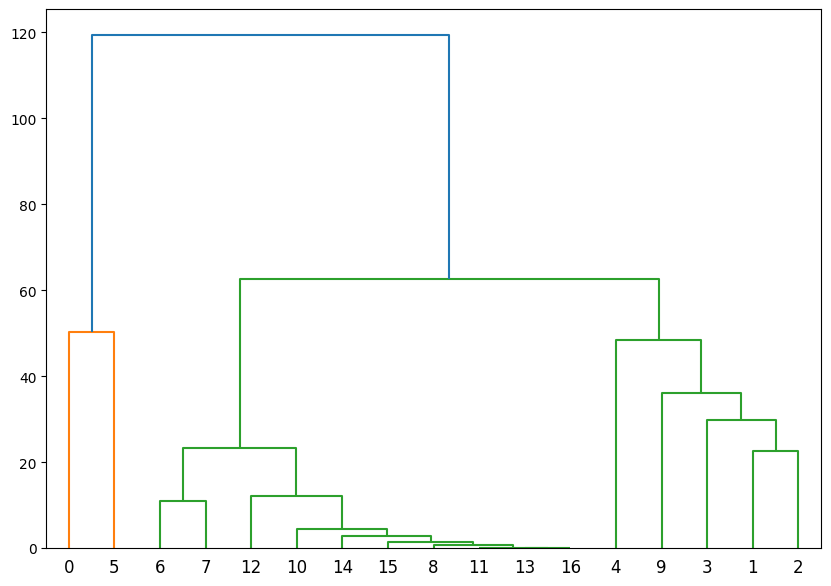

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from dtaidistance import dtw
from fastdtw import fastdtw

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster


def cut_tree_dynamic(linkage_matrix, min_module_size=2):
    n = linkage_matrix.shape[0] + 1
    clusters = np.arange(n)
    
    for i in range(n-1):
        if np.sum(clusters == clusters[int(linkage_matrix[i, 0])]) >= min_module_size and \
           np.sum(clusters == clusters[int(linkage_matrix[i, 1])]) >= min_module_size:
            clusters[clusters == clusters[int(linkage_matrix[i, 0])]] = n + i
            clusters[clusters == clusters[int(linkage_matrix[i, 1])]] = n + i
    
    return clusters

# Suppose that df2 has already been loaded and processed as in your previous steps
X = df2.T.values

# Normaliser les séries temporelles
scaler =  TimeSeriesScalerMeanVariance(mu=0., std=1.)
#sales_time_series_norm = scaler.fit_transform(X)
sales_time_series_norm = zscore(X)

# Calculer la matrice de distance en utilisant DTW
n_series = sales_time_series_norm.shape[0]
distance_matrix = np.zeros((n_series, n_series))
for i in range(n_series):
    for j in range(i+1, n_series):
        dist, _ = fastdtw(sales_time_series_norm[i], sales_time_series_norm[j])
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist

# Convertir la matrice de distance en forme de vecteur
distance_matrix_condensed = squareform(distance_matrix)


my_dist_norm = dtw.distance_matrix_fast(sales_time_series_norm)

# Si vous voulez normaliser la distance (comme indiqué par normalize=TRUE dans le code R)
my_dist_norm = my_dist_norm / np.max(my_dist_norm)

linkage_matrix = linkage(distance_matrix_condensed, method='complete')

# Créer le dendrogramme
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)

# # Appliquer la fonction de coupe dynamique
# clusters_norm = cut_tree_dynamic(linkage_matrix, min_module_size=2)
# print(clusters_norm)
silhouette_avg = silhouette_score(distance_matrix, clusters, metric='precomputed')

print(f'Silhouette Score: {silhouette_avg}')


Clusters: [10  5  6  7  9 11  1  2  3  8  3  3  4  3  3  3  3]
Silhouette Score: 0.31781432279677974


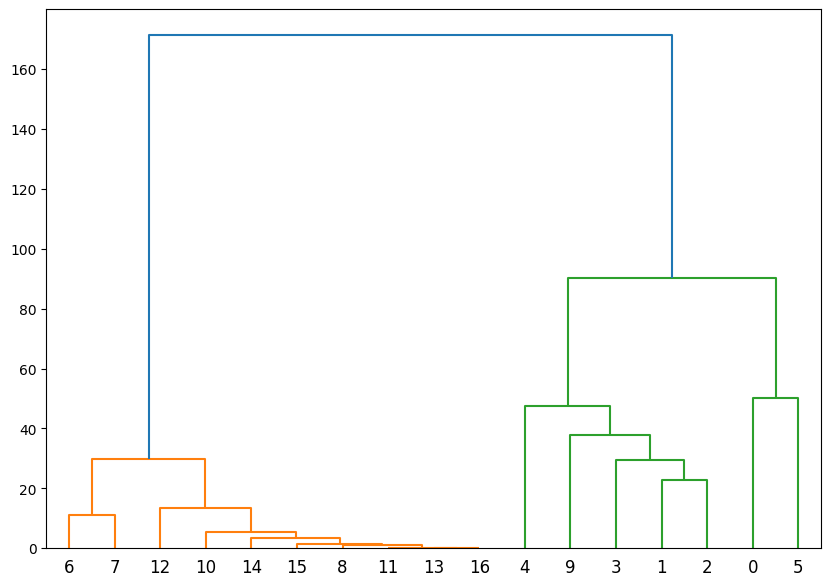

In [21]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist, squareform
from fastdtw import fastdtw
from sklearn.metrics import silhouette_score

# Exemple des données d'entrée
X = df2.T.values  # À utiliser avec vos données réelles

# Normalisation des données
scaler = StandardScaler()
#X_normalized = scaler.fit_transform(X)
X_normalized = zscore(X)

# Calcul de la matrice de distance DTW
def dtw_distance_matrix(X):
    n = X.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            distance, _ = fastdtw(X[i], X[j])
            dist_matrix[i, j] = distance
            dist_matrix[j, i] = distance
    return dist_matrix

dist_matrix = dtw_distance_matrix(X_normalized)

# Conversion de la matrice de distance en format compatible avec linkage
dist_array = squareform(dist_matrix)

# Clustering hiérarchique avec la méthode de linkage "complete"
linkage_method = 'ward'
Z = linkage(dist_array, method=linkage_method)

plt.figure(figsize=(10, 7))
dendrogram(Z)

# Coupure du dendrogramme pour obtenir les clusters avec au moins 2 éléments par cluster
# On peut ajuster t selon le besoin
t = 10  # Seuil à ajuster en fonction de vos données spécifiques
clusters = fcluster(Z, t=t, criterion='distance')

# Calcul de l'indice de silhouette
silhouette_avg = silhouette_score(dist_matrix, clusters, metric='precomputed')

print(f'Clusters: {clusters}')
print(f'Silhouette Score: {silhouette_avg}')
